# Movement Analysis
This journal will calculate and plot the movement of rats in the open field

In [1]:
# This cell will import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os import listdir
from IPython.display import display
import scipy.integrate

In [2]:
%%capture
from tqdm import tqdm_notebook as pbar
pbar().pandas()

# This is a housekeeping cell that initializes the progress bar
# This cell also prompts the user to define what condition is being analyzed

font = {'fontname':'Liberation Serif'}

Experiment=input("Enter either Sham or PD: ")

CON='/Output/'+Experiment

Enter either Sham or PD: Sham


In [3]:
# This cell will import data files as dataframes

# File path to be used while importing and merging
data_path='/home/sam/Science/microdialysis/MSDissertation/Behavior/DLC_CSVs/'+Experiment+'/'

# Code for finding names of all CSVs in the specified folder 
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

file_names = find_csv_filenames(data_path)
print("This directory contains",str((len(file_names))),"files which have been loaded")

# This function will sequentially (i) read each CSV, (ii) give it an experiment ID, and (iii) merge it with the other CSVs
def loader(data_path):
    experiments = pd.DataFrame()
    IndexNS=int(0)
    IndexS=int(0)
    for name in pbar(file_names):
        file_path=data_path+name      
        
#         Opens given file in temporary dataframe
#            NOTE THIS IS CONFIGURED SUCH THAT THE HEADER IS LINES 1 AND 2
        store = pd.read_csv(file_path, header=[1,2])


#         Adds CSV ID to avoid confusion
        for ii in range(len(store)):
            store.loc[ii, "CSV"] = name

#           Adds condition of SCS
            if ('unstim' in name):
                store.loc[ii,"Condition"]="Not Stimulated"
                store.loc[ii,"Index"]=IndexNS
                IndexNS=IndexNS+1
            elif ('post-stim' in name):
                store.loc[ii,"Condition"]="Post Stimulation"
                store.loc[ii,"Index"]=IndexNS
            else:
                store.loc[ii,"Condition"]="Stimulated"
                store.loc[ii,"Index"]=IndexS
                IndexS=IndexS+1


#         Appends CSV
        experiments = experiments.append(store)

    return(experiments)

experiments=loader(data_path)

print("The experiments dataframe has",str((len(experiments))),"rows")

This directory contains 6 files which have been loaded



The experiments dataframe has 288080 rows


## Calculations
In this experiment, it is desired to identify the position of individual animals during thir respective runs, the average velocity for animals with or without stimulation, and the average head to tail distance of animals from different conditions; the latter two measurements are proxies for the human symptoms of bradykinesia and hunching, respectively.

To ascertain these values,the data sets are first parsed based on stimulation condition. The difference between consecutive frames is then found for each measurment of each animal, as is the average $X$ and $Y$ position for all six tracked body parts. The average position is converted from pixel values into cm (in this open field set up 20.2 pixels are measured for every centimeter). The reason for averaging all body parts is to provide a prediction for the animal's center of mass, which in effect should filter the jitters that are observed during tracking.

Finally, hunching ($D$) is calculated based on the pythaorean theorem: $$D=\sqrt{(X_{Nose}-X_{Tail Base})^{2}+(Y_{Nose}-Y_{Tail Base})^{2}}$$
One limitiation to be aware of, is that the tracking is unable to differentiate when the animals head is at a different altitude. Thus a false positive for hunching can be expected for rearing behaviors, when the head is actually at the fartherest real distance from the tail base, but to the tracking software appears to be closer to the tail base.

For statistical analysis, the standard deviation of all delta values is found. When creating compound values, such as the COM, it is assummed that $X_{1}$ and $X_{2}$ are indepedent, as are $Y_{1}$ and $Y_{2}$. As a result the variance between their difference is given by $$Var[X_{2} - X_{1}] = Var[X_{2}] + Var[X_{1}]$$ and $$Var[Y_{2} - Y_{1}] = Var[Y_{2}] + Var[Y_{1}]$$ Following this calculation for the differences of the new delta values are assumed to be independent, inspite of the fact that $X_{1}$ and $Y_{1}$ and $X_{2}$ and $Y_{2}$ are dependent. Therefore the equation used to compute the composite standard deviations is: $$Std[dX, dY] = \sqrt{Std[X_{2}]^{2} + Std[X_{1}]^{2} + Std[Y_{2}]^{2} + Std[Y_{1}]^{2}}$$

In [4]:
#This cell will compute and store the change in position for each body part per frame, 
    #the change in the center of mass (COM) for the animal for each frame
        #and the distance betwen the head and tailbase (Hunch) in each frame

def Delter(df):
    
    delta=pd.DataFrame()
    frame=0
    time=0

#     reset column index for following loop   
    df=df.reset_index()

    for index in pbar(range(len(df)-1)):
        
#         This control statement will partition experiments
        if (df.loc[(index+1),"CSV"][0])==(df.loc[index,"CSV"][0]):
#             Calculation of delta for each value
            delta.loc[index,"Nose X"]=df.loc[index+1,"Nose"]["x"]-df.loc[index,"Nose"]["x"]
            delta.loc[index,"Nose Y"]=df.loc[index+1,"Nose"]["y"]-df.loc[index,"Nose"]["y"]
            delta.loc[index,"RFPaw X"]=df.loc[index+1,"RFPaw"]["x"]-df.loc[index,"RFPaw"]["x"]
            delta.loc[index,"RFPaw Y"]=df.loc[index+1,"RFPaw"]["y"]-df.loc[index,"RFPaw"]["y"]
            delta.loc[index,"LFPaw X"]=df.loc[index+1,"LFPaw"]["x"]-df.loc[index,"LFPaw"]["x"]
            delta.loc[index,"LFPaw Y"]=df.loc[index+1,"LFPaw"]["y"]-df.loc[index,"LFPaw"]["y"]
            delta.loc[index,"RHPaw X"]=df.loc[index+1,"RHPaw"]["x"]-df.loc[index,"RHPaw"]["x"]
            delta.loc[index,"RHPaw Y"]=df.loc[index+1,"RHPaw"]["y"]-df.loc[index,"RHPaw"]["y"]
            delta.loc[index,"LHPaw X"]=df.loc[index+1,"LHPaw"]["x"]-df.loc[index,"LHPaw"]["x"]
            delta.loc[index,"LHPaw Y"]=df.loc[index+1,"LHPaw"]["y"]-df.loc[index,"LHPaw"]["y"]
            delta.loc[index,"TailBase X"]=df.loc[index+1,"TailBase"]["x"]-df.loc[index,"TailBase"]["x"]
            delta.loc[index,"TailBase Y"]=df.loc[index+1,"TailBase"]["y"]-df.loc[index,"TailBase"]["y"]
            
#             Calculation of center of mass, ignoring NaN
            
            delta.loc[index,"COM X"]=np.nanmean([delta.loc[index,"Nose X"],
                                                delta.loc[index,"RFPaw X"],
                                                delta.loc[index,"LFPaw X"],
                                                delta.loc[index,"RHPaw X"],
                                                delta.loc[index,"LHPaw X"],
                                                delta.loc[index,"TailBase X"]])
                                                
            delta.loc[index,"COM Y"]=np.nanmean([delta.loc[index,"Nose Y"],
                                                delta.loc[index,"RFPaw Y"],
                                                delta.loc[index,"LFPaw Y"],
                                                delta.loc[index,"RHPaw Y"],
                                                delta.loc[index,"LHPaw Y"],
                                                delta.loc[index,"TailBase Y"]])
    
#             Calculation of hunch

            delta.loc[index,"Hunch"] = np.sqrt((df.loc[index,"Nose"]["x"]-df.loc[index,"TailBase"]["x"])**2 + (df.loc[index,"Nose"]["y"]-df.loc[index,"TailBase"]["y"])**2) 
    

#             Storage of frame number
            delta.loc[index,"Frame"]=frame
            frame=frame+1
            delta.loc[index,"Time (min)"]=time
            time=time+0.00055555555

        else:
            print("Assessing next file")
            frame=0
            time=0
       
        delta.reset_index()

    return(delta)    


data_path='/home/sam/Science/microdialysis/MSDissertation/Behavior/DLC_CSVs/'
file_path1=data_path+CON+'_Unstim_delta.csv'
file_path2=data_path+CON+'_Stim_delta.csv'
file_path3=data_path+CON+'_Post-Stim_delta.csv'

NStim_delta=Delter(experiments.loc[(experiments.loc[:,"Condition"]=='Not Stimulated'),:])

NStim_delta.to_csv(file_path1)

print("Separation of unstimulation experiments, and calculation of deltas complete")

Stim_delta=Delter(experiments.loc[(experiments.loc[:,"Condition"]=='Stimulated'),:])

Stim_delta.to_csv(file_path2)

print("Separation of stimulation experiments, and calculation of deltas complete")

Post_delta=Delter(experiments.loc[(experiments.loc[:,"Condition"]=='Post Stimulation'),:])

Post_delta.to_csv(file_path3)

print("Separation of post-stimulation experiments, and calculation of deltas complete")


Assessing next file
Assessing next file

Separation of unstimulation experiments, and calculation of deltas complete


Assessing next file
Assessing next file

Separation of stimulation experiments, and calculation of deltas complete



Separation of post-stimulation experiments, and calculation of deltas complete


In [5]:
print# This filter takes an inpt dataframe and averages every N frames
#   By averaging 3 frames for instance, this function can remove erroroneous jitters sometimes observed durin the tracking
#   By averaging 30 frames alternatively, the relevant dataframe is converted from a per frame measuremnt to a per second measurement
def filtN(df, Name, N):
    ii=0
    jj=0
    kk=0
    temp=0
    time=0
    store=pd.DataFrame()
    while ii <= (len(df)-N):
        while jj <(N+1):
            temp=temp+df[ii]
            ii+=1
            jj+=1
        time=time+(0.0005555555*N)
        store.loc[kk,Name]=(temp/N)
        store.loc[kk,"Time (min)"]=time
        jj=0
        temp=0
        kk+=1
    return(store)


# This version is for std, it works by finding the square root of the sum of the variances, which are the squares of the std
def filtN_std(df, Name, N):
    ii=0
    jj=0
    kk=0
    temp=0
    time=0
    store=pd.DataFrame()
    while ii <= (len(df)-N):
        while jj <(N+1):
            temp=temp+df[ii]**2
            ii+=1
            jj+=1
        time=time+(0.0005555555*N)
        store.loc[kk,Name]=(np.sqrt(temp)/N)
        store.loc[kk,"Time (min)"]=time
        jj=0
        temp=0
        kk+=1
    return(store)

In [6]:
# This cell calculates the average value for all higher order values

def Avrger(delta):
    store=pd.DataFrame()
    
    delta=delta.reset_index()
#     The Frame number will be used as the index so as to align different experiments
    delta.set_index("Frame")
    
#This loop will calculate and store the average value for the higher order values from the experiments based on identical frame IDs
# The loop is using the last identified frame as the index, as this input DF contains multiple videos of roughly equal legnth
    for index in pbar(range(int(max(delta["Frame"])))):
        store.loc[index,"Nose X"]=np.nanmean(delta["Nose X"][delta["Frame"]==index])
        store.loc[index,"Nose Y"]=np.nanmean(delta["Nose Y"][delta["Frame"]==index])
        store.loc[index,"RFPaw X"]=np.nanmean(delta["RFPaw X"][delta["Frame"]==index])
        store.loc[index,"RFPaw Y"]=np.nanmean(delta["RFPaw Y"][delta["Frame"]==index])
        store.loc[index,"LFPaw X"]=np.nanmean(delta["LFPaw X"][delta["Frame"]==index])
        store.loc[index,"LFPaw Y"]=np.nanmean(delta["LFPaw Y"][delta["Frame"]==index])
        store.loc[index,"RHPaw X"]=np.nanmean(delta["RHPaw X"][delta["Frame"]==index])
        store.loc[index,"RHPaw Y"]=np.nanmean(delta["RHPaw Y"][delta["Frame"]==index])
        store.loc[index,"LHPaw X"]=np.nanmean(delta["LHPaw X"][delta["Frame"]==index])
        store.loc[index,"LHPaw Y"]=np.nanmean(delta["LHPaw Y"][delta["Frame"]==index])
        store.loc[index,"TailBase X"]=np.nanmean(delta["TailBase X"][delta["Frame"]==index])
        store.loc[index,"TailBase Y"]=np.nanmean(delta["TailBase Y"][delta["Frame"]==index])
        store.loc[index,"COM X"]=np.nanmean(delta["COM X"][delta["Frame"]==index])
        store.loc[index,"COM Y"]=np.nanmean(delta["COM Y"][delta["Frame"]==index])
        store.loc[index,"Hunch"]=np.nanmean(delta["Hunch"][delta["Frame"]==index])
        
        store.loc[index,"Nose X std"]=np.std(delta["Nose X"][delta["Frame"]==index])
        store.loc[index,"Nose Y std"]=np.std(delta["Nose Y"][delta["Frame"]==index])
        store.loc[index,"RFPaw X std"]=np.std(delta["RFPaw X"][delta["Frame"]==index])
        store.loc[index,"RFPaw Y std"]=np.std(delta["RFPaw Y"][delta["Frame"]==index])
        store.loc[index,"LFPaw X std"]=np.std(delta["LFPaw X"][delta["Frame"]==index])
        store.loc[index,"LFPaw Y std"]=np.std(delta["LFPaw Y"][delta["Frame"]==index])
        store.loc[index,"RHPaw X std"]=np.std(delta["RHPaw X"][delta["Frame"]==index])
        store.loc[index,"RHPaw Y std"]=np.std(delta["RHPaw Y"][delta["Frame"]==index])
        store.loc[index,"LHPaw X std"]=np.std(delta["LHPaw X"][delta["Frame"]==index])
        store.loc[index,"LHPaw Y std"]=np.std(delta["LHPaw Y"][delta["Frame"]==index])
        store.loc[index,"TailBase X std"]=np.std(delta["TailBase X"][delta["Frame"]==index])
        store.loc[index,"TailBase Y std"]=np.std(delta["TailBase Y"][delta["Frame"]==index])
        store.loc[index,"COM X std"]=np.std(delta["COM X"][delta["Frame"]==index])
        store.loc[index,"COM Y std"]=np.std(delta["COM Y"][delta["Frame"]==index])
        store.loc[index,"Hunch std"]=np.std(delta["Hunch"][delta["Frame"]==index])
        
        
        store.loc[index,"Frame"]=(delta.loc[index,"Frame"]*20.2)
        store.loc[index,"Time (min)"]=(delta.loc[index,"Time (min)"]*20.2)
        
#     Convert pixel value into cm 
    store=store/20.2

    return(store)


file_path1=data_path+CON+'/Unstim_Av.csv'
file_path2=data_path+CON+'/Stim_Av.csv'
file_path3=data_path+CON+'_Post-Stim_Av.csv'

NStim_Av=Avrger(NStim_delta)

NStim_Av.to_csv(file_path1)

print("Unstimulated runs averaged with",len(NStim_Av), "frames")

Stim_Av=Avrger(Stim_delta)

Stim_Av.to_csv(file_path2)

print("Stimulated runs averaged",len(Stim_Av), "frames")

if len(experiments.loc[(experiments.loc[:,"Condition"]=='Post Stimulation'),:]) >0:
    Post_Av=Avrger(Post_delta)

    Post_Av.to_csv(file_path3)

    print("Post-stimulated runs averaged",len(Post_Av), "frames")


Unstimulated runs averaged with 54405 frames



Stimulated runs averaged 54085 frames


## Plotting
The extracted values are now plotted in this section

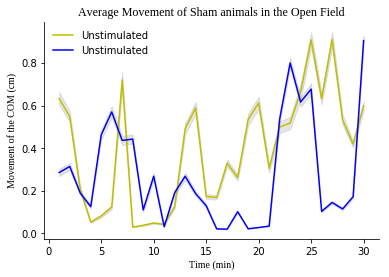

In [7]:
#This cell first calculates and then plots the center of mass at each frame

def COMer(delta):
    
    COM=pd.DataFrame()
       
    for index in pbar(range(len(delta)-1)):

        COM.loc[index,"COM"] = np.sqrt((delta.loc[index+1,"COM X"]-delta.loc[index,"COM X"])**2 + (delta.loc[index+1,"COM Y"]-delta.loc[index,"COM Y"])**2)    
        
        COM.loc[index,"COM std"] = np.sqrt((delta.loc[index+1,"COM X std"]**2+delta.loc[index,"COM X std"]**2+delta.loc[index+1,"COM Y std"]**2+delta.loc[index,"COM Y std"]**2))
        
    return(COM)

COMs=COMer(Stim_Av)

COMn=COMer(NStim_Av)

# This filter will average every 60*30=1800 frames to remove outliers and express the data in average per minute
x=filtN(COMs['COM'],"Stimulated",1800)
y=filtN(COMn['COM'],"Unstimulated",1800)
a=filtN_std(COMs['COM std'],"Stimulated std",1800)
b=filtN_std(COMn['COM std'],"Unstimulated std",1800)


# The separate stimulated and unstimulated series are merged for easy plotting
COM=x.merge(y)
COM=COM.merge(a)
COM=COM.merge(b)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)


# If post-stimulation runs are present
if len(experiments.loc[(experiments.loc[:,"Condition"]=='Post Stimulation'),:]) >0:
    COMp=COMer(Post_Av)
    z=filtN(COMp['COM'],"Post-stimulated",3)
    z=filtN(z['Post-stimulated'],"Post-stimulated",20)
    c=filtN_std(COMn['COM std'],"Post-stimulated std",1800)
    COM=COM.merge(z)
    COM=COM.merge(c)
    plt.plot(COM["Post-stimulated"], label="Post-Stimulated", color ='g')
    
#X-axis parameters

ax.set_xlabel("Time (min)", **font)

#ax.errorbar(COM["Time (min)"],COM["Stimulated"], yerr=COM["Stimulated std"], label="Stimulated", lw=2, capsize=3, capthick=2, color='k')
ax.plot(COM["Time (min)"],COM["Stimulated"],label="Unstimulated",color='y')
ax.fill_between(COM["Time (min)"],COM["Stimulated"] - COM["Stimulated std"], COM["Stimulated"] + COM["Stimulated std"],
                 color='gray', alpha=0.2)


#ax.errorbar(COM["Time (min)"],COM["Unstimulated"], yerr=COM["Unstimulated std"], label="Unstimulated", lw=2, capsize=3, capthick=2, color='k')
ax.plot(COM["Time (min)"],COM["Unstimulated"],label="Unstimulated",color='b')
ax.fill_between(COM["Time (min)"],COM["Unstimulated"] - COM["Unstimulated std"], COM["Unstimulated"] + COM["Unstimulated std"],
                 color='gray', alpha=0.2)



#Y-axis parameters
ax.set_ylabel('Movement of the COM (cm)', **font)

#Title and legend parameters
ax.set_title(("Average Movement of "+CON[8::]+ " animals in the Open Field"), **font)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon=False)

display()

file_path1=data_path+CON+'/COM.csv'
file_path2=data_path+CON+'/COM.png'

COM.to_csv(file_path1)

plt.savefig(file_path2, dpi=300, transparent=True)

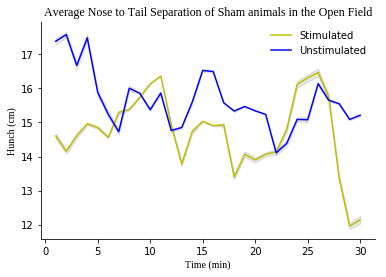

In [8]:
#This cell plots the Nose to tail distance at each frame

#This filter will remove any measurements over 25 cm, as they are impossible and DLC was clearly tracking something erroneously for longer than one second
def stretchfilt(df, cat):
    for ii in range(len(df)):
        if df[cat][ii]>25:
            df.loc[ii,cat]=25
    return(df)

# This filter will average every 3 frames to remove single frame outliers
#    In effect the frame rate has now dropped from 30 fps to 10 fps
x=filtN(Stim_Av['Hunch'],"Stimulated",1800)

x=stretchfilt(x, 'Stimulated')

y=filtN(NStim_Av['Hunch'],"Unstimulated",1800)

y=stretchfilt(y, 'Unstimulated')

a=filtN_std(Stim_Av['Hunch std'],"Stimulated std",1800)
b=filtN_std(NStim_Av['Hunch std'],"Unstimulated std",1800)

# This filter will down sample from 10 fps to 1 fps, such that differences are now on a persecond basis
#x=filtN(x["Stimulated"],"Stimulated",20)
#y=filtN(y["Unstimulated"],"Unstimulated",20)


# The separate stimulated and unstimulated series are merged for easy plotting
Hunch=x.merge(y)
Hunch=Hunch.merge(a)
Hunch=Hunch.merge(b)


fig = plt.figure()
ax = fig.add_subplot(111)  

# If post-stimulation runs are present
if len(experiments.loc[(experiments.loc[:,"Condition"]=='Post Stimulation'),:]) >0:
    z=filtN(Post_Av['Hunch'],"Post-stimulated",3)
    z=filtN(z['Post-stimulated'],"Post-stimulated",20)
    z=stretchfilt(z,"Post-stimulated")
    c=filtN_std(Post_Av['Hunch std'],"Post-stimulated std",1800)
    Hunch=Hunch.merge(z)
    Hunch=Hunch.merge(c)
    plt.plot(Hunch["Post-stimulated"], label="Post-Stimulated", color ='g')
    ax.fill_between(Hunch["Time (min)"],Hunch["Post-Stimulated"] - Hunch["Post-Stimulated std"], Hunch["Post-Stimulated"] + Hunch["Post-Stimulated std"],
                 color='gray', alpha=0.2)


#X-axis parameters
ax.set_xlabel("Time (min)", **font)
ax.plot(Hunch["Time (min)"],Hunch["Stimulated"], label="Stimulated", color='y')
ax.fill_between(Hunch["Time (min)"],Hunch["Stimulated"] - Hunch["Stimulated std"], Hunch["Stimulated"] + Hunch["Stimulated std"],
                 color='gray', alpha=0.2)

ax.plot(Hunch["Time (min)"],Hunch["Unstimulated"], label="Unstimulated", color='b')
ax.fill_between(Hunch["Time (min)"],Hunch["Unstimulated"] - Hunch["Unstimulated std"], Hunch["Unstimulated"] + Hunch["Unstimulated std"],
                 color='gray', alpha=0.2)

#Y-axis parameters
ax.set_ylabel('Hunch (cm)', **font)

#Title and legend parameters
ax.set_title(("Average Nose to Tail Separation of "+CON[8::]+ " animals in the Open Field"), **font)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon=False)

display()

file_path1=data_path+CON+'/Hunch.csv'
file_path2=data_path+CON+'/Hunch.png'

Hunch.to_csv(file_path1)

plt.savefig(file_path2, dpi=300, transparent=True)

In [9]:
#This cell will compute the sum of the movement for each input video, it was one option for finding total distance moved, but a more elegant solution is to use the integer of the average and thus this cell is depracated but not deleted incase future analysis is interested in comparing the two methods

# This function will compute the sum of each video from a given delta condition
def summarizer(delta,name):

# These local variables are initialized
    animal=pd.DataFrame()
    summy=0
    ii=0

# This loop iterates through the full legnth of delta df
    for index in range(len(delta)+1):
#     This loop will add all values after calculating the distancetraveled frame by frame
            try:
                COM = np.sqrt((delta.loc[index+1,"COM X"]-delta.loc[index,"COM X"])**2 + (delta.loc[index+1,"COM Y"]-delta.loc[index,"COM Y"])**2)    
                
                summy=summy+COM
# A gap exists when in the df delta where each new video begins and the key exception that results is used to store the sum of the previous video
            except KeyError:
            
                animal.loc[ii,name]=summy
#             ii is the index for the output df sunnny where each row is a different video
                ii=ii+1
                #pass
                summy=0
                
    return(animal)    

sum_unstim=NStim_delta
sum_stim=Stim_delta
sum_stim=summarizer(sum_stim,"Stimulated")
sum_unstim=summarizer(sum_unstim,"Unstimulated")

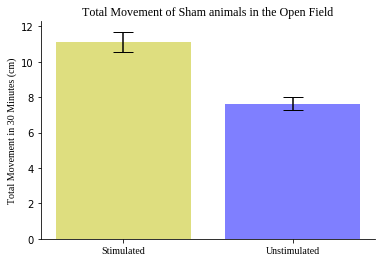

In [11]:
U=COM["Unstimulated"]
U_high=COM["Unstimulated"]+COM["Unstimulated std"]
U_low=COM["Unstimulated"]-COM["Unstimulated std"]

# The integral of the averge change in movement is found in order to calculate the total movement during the recoridn period
U=scipy.integrate.simps(U,COM['Time (min)'],U)
U_error=[scipy.integrate.simps(U_high,COM['Time (min)']), 
         scipy.integrate.simps(U_low,COM['Time (min)'])]


# The integral of the averge change in movement is found in order to calculate the total movement during the recoridn period
S=COM["Stimulated"]
S_high=COM["Stimulated"]+COM["Stimulated std"]
S_low=COM["Stimulated"]-COM["Stimulated std"]

S=scipy.integrate.simps(S,COM['Time (min)'])
S_error=[scipy.integrate.simps(S_high,COM['Time (min)']), 
         scipy.integrate.simps(S_low,COM['Time (min)'])]

# Plotting bar graph of total movement observed
fig = plt.figure()
ax = fig.add_subplot(111)

#X-axis parameters
ax.set_xticks([1,2])
ax.set_xticklabels(["Stimulated","Unstimulated"], **font)
plt.setp(plt.xticks()[1], rotation=0)

ax.bar([1,2], [S,U], yerr=[(S-S_error[1]),(U-U_error[1])], align='center', alpha=0.5, color=['y','b'],ecolor='black', capsize=10)

#Y-axis parameters
ax.set_ylabel('Total Movement in 30 Minutes (cm)', **font)

#Title and legend parameters
ax.set_title(("Total Movement of "+CON[8::]+ " animals in the Open Field"), **font)
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend(frameon=False)

display()

file_path2=data_path+CON+'/Tot_mov.png'

plt.savefig(file_path2, dpi=300, transparent=True)